# **Dependancy**

In [ ]:
pip install deepxde

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras.layers 

from google.colab import files
import io

import tensorboard
from datetime import datetime

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import deepxde as dde
from deepxde.backend import tf

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from tensorflow.python.keras.utils.vis_utils import plot_model

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# **Prepare Data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Jumps to the desired directory
%cd 'drive/My Drive/Analytical Data'
p1 = genfromtxt('T_q100_v200_T25_D100.csv', delimiter=',')
times = genfromtxt('time.csv', delimiter=',')
times = times.reshape((100,1))
print("times.shape:", times.shape)
times[0:5]
points = p1[:, 1:3]
print("points.shape:",points.shape)
temps = p1[:, 5:]
print("temps.shape:",temps.shape)

/content/drive/My Drive/Analytical Data
times.shape: (100, 1)
points.shape: (1681, 2)
temps.shape: (1681, 100)


**Re-arranging**

In [5]:
all_ = []

for j in range(100):
  new_points = np.zeros((1681, 3))
  for i in range(1681):
      new_points[i] = [points[i][0], points[i][1], times[j] * 1000] # y, z, t 
  all_.append(new_points)

new_temps = temps[:,:]
print("new_points.shape:", new_points.shape)
print("new_temps.shape:",new_temps.shape)
print("all_ is a list of length", len(all_))
print("each element in all_ has the shape of ", all_[0].shape)

new_points.shape: (1681, 3)
new_temps.shape: (1681, 100)
all_ is a list of length 100
each element in all_ has the shape of  (1681, 3)


**Split the train and test data based on K-Means clustering**

In [6]:
# Cluster just based on the coordinates (0:3)
point = points[:,:]
kmeans = KMeans(n_clusters= 10)
kmeans = kmeans.fit(point)
labels = kmeans.predict(point)

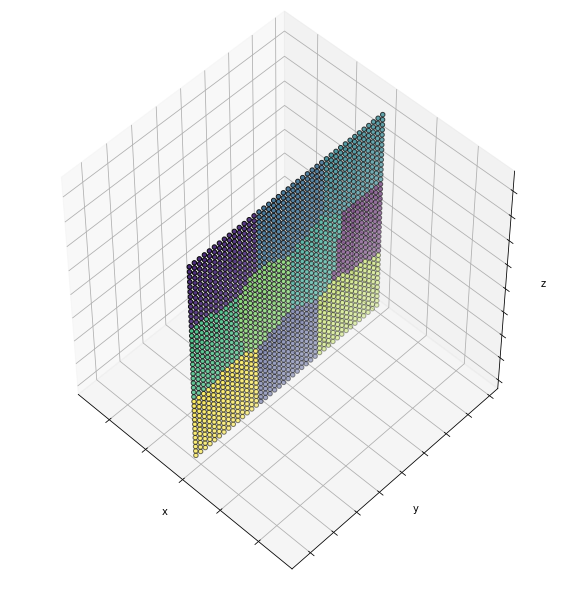

In [7]:
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(p1[:, 0], point[:, 0], point[:, 1], c=labels.astype(np.float), edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
fig.show()

In [8]:
mydict = {i: np.where(labels == i)[0] for i in range(kmeans.n_clusters)}
dictlist = []
for key, value in mydict.items():
    dictlist.append(value)

train_indices = []
test_indices = []
for l in dictlist:
  train_indices.extend(l[0 : int(len(l) * 0.85)])
  test_indices.extend(l[int(len(l) * 0.85) : ])

print("Number of training samples: ", len(train_indices))
print("Number of testing samples: ", len(test_indices))
print("We use 85 percent of the data for training and the rest 15 percent for testing.")

Number of training samples:  1424
Number of testing samples:  257
We use 85 percent of the data for training and the rest 15 percent for testing.


# **Model and PINN**

**Defining Required functions**

In [9]:
# defining the pde
def pde(x, y):
  dy_x = tf.gradients(y, x)[0]
  dy_x1, dy_x2, dy_t = dy_x[:, 0:1], dy_x[:, 1:2], dy_x[:, 2:]
  dy_x1x1 = tf.gradients(dy_x1, x)[0][:, 0:1]
  dy_x2x2 = tf.gradients(dy_x2, x)[0][:, 1:2]
  return (dy_t - (dy_x1x1 - dy_x2x2))

def func(x):
  return np.full((len(x), 1), 10e-2)

def funcic(x): return np.full((len(x), 1), 25)

def funcbc(x):  # x = the collection of the points on the boundary 
  result = np.zeros((len(x), 1))
  for i in range(len(x)):
    result[i] = map_dict[(x[i][0], x[i][1], x[i][2])]  # 0: y, 1: z, 2 : time
  return result

def solution(x) :
  result = np.zeros((len(x), 1))
  for i in range(len(x)):
    result[i] = map_dict[(x[i][0], x[i][1], x[i][2])]  # 0: y, 1: z, 2 : time
  return result

**Defining Required Variables**

In [10]:
# early stopping
callback = dde.callbacks.EarlyStopping(min_delta=0.001, patience=3000)

# defining the geometry
geom = dde.geometry.geometry_2d.Rectangle((1,1), (41,41))
timedomain = dde.geometry.TimeDomain(0, 10)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


# defining the model
layer_size = [3] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

**Retraining Step**

In [11]:
for time_step in range(70):

  # preparing data for this specific time step
  train_x = all_[time_step][train_indices]
  train_y = new_temps[train_indices, time_step].reshape((len(train_indices),1))
  map_dict =  {}
  for i in range(len(train_x)):
    map_dict[(train_x[i][0], train_x[i][1], train_x[i][2])] = train_y[i]

  # defining the boundary and initial conditions
  bc = dde.DirichletBC(geomtime, funcbc, lambda _, on_boundary: on_boundary)
  ic = dde.IC(geomtime, funcic, lambda _, on_initial: on_initial)


  # defining the data in deepxde format
  data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_boundary = 0, num_domain = 0, anchors = train_x, solution = solution)

  print("Time Step :", time_step)
  
  n_epochs = 8000
  if 20 < time_step < 50 :
    n_epochs = 3000
  if time_step > 40 :
    n_epochs = 6000

  # In the first time-step, just store the model. In the following ones, first restre, then train and then store again.
  if time_step == 0:
    model = dde.Model(data, net)
    model.compile("adam", lr=0.001,metrics=["l2 relative error"])
    losshistory, train_state = model.train(epochs=n_epochs)
    model.saver.save(model.sess, "model/modelclustering")
  else:
    model.data = data
    model.saver.restore(model.sess, "model/modelclustering")
    model.compile("adam", lr=0.001,metrics=["l2 relative error"])
    losshistory, train_state = model.train(epochs=n_epochs)
    model.saver.save(model.sess, "model/modelclustering")

Time Step : 0
Compiling model...
Building feed-forward neural network...
'build' took 0.073834 s



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.904838 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.19e-02, 3.69e+03, nan]         [1.19e-02, 0.00e+00, 0.00e+00]    [1.02e+00]    
1000      [1.90e-07, 1.31e+03, nan]         [1.90e-07, 0.00e+00, 0.00e+00]    [4.75e-01]    
2000      [9.75e-08, 1.09e+03, nan]         [9.75e-08, 0.00e+00, 0.00e+00]    [5.05e-01]    
3000      [6.84e-01, 1.02e+03, nan]         [6.84e-01, 0.00e+00, 0.00e+00]    [5.34e-01]    
4000      [3.58e-02, 1.01e+03, nan]         [3.58e-02, 0.00e+00, 0.00e+00]    [5.54e-01]    
5000      [3.87e-02, 2.39e+02, nan]         [3.87e-02, 0.00e+00, 0.00e+00]    [2.01e-01]    
6000      [4.44e-02, 5.68e+01, nan]         [4.44e-02, 0.00e+00, 0.00e+00]    [1.59e-01]    
7000      [4.92e-02, 1.37e+01, nan]         [4.92e-02, 0.00e+00, 0.00e+00]    [1.58e-01]    
8000      [3.58e-02, 2.92e+00, nan]         [3.58e-02, 0.00e+00, 0.00e+00]    [1.49e-01]   

# Plotting Boundary

**Finding Boundary**

In [12]:
import deepxde as dde
def func(x):
  return np.full((len(x), 1), 10e-2)
geom = dde.geometry.geometry_2d.Rectangle((1,1), (41,41))
timedomain = dde.geometry.TimeDomain(0, 0.01) 
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
bc = dde.DirichletBC(geomtime, funcbc, lambda _, on_boundary: on_boundary)

In [13]:
boundary = bc.collocation_points(train_x)
temps_on_boundary = np.zeros((len(boundary), 1))
for i in range(len(boundary)):
  temps_on_boundary[i] = map_dict[(boundary[i][0], boundary[i][1], boundary[i][2])] 
all_boundary = np.concatenate((boundary, temps_on_boundary), axis = 1)

**Plotting Boundary**

In [14]:
all_boundary.shape

(110, 4)

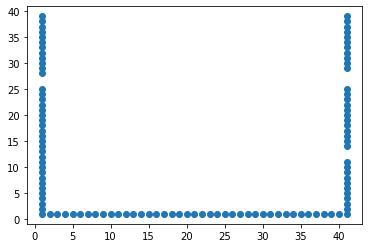

In [15]:
import matplotlib.pyplot as plt
plt.scatter(all_boundary[:,0], all_boundary[:,1]) 

# Plotting and Predictions

In [ ]:
# train prediction
all_train_predicted = []
for i in range(70):
  train_x = all_[i][train_indices]
  train_y = new_temps[train_indices, i].reshape((len(train_indices),1))
  pred = model.predict(train_x)
  all_train_predicted.append(pred)

In [17]:
print(len(all_train_predicted))
print(all_train_predicted[0].shape)

70
(1424, 1)


In [ ]:
# test prediction
all_test_predicted = []
for i in range(70):
  test_x = all_[i][test_indices]
  test_y = new_temps[test_indices, i].reshape((len(test_indices),1))
  pred = model.predict(test_x)
  all_test_predicted.append(pred)

In [19]:
print(len(all_test_predicted))
print(all_test_predicted[0].shape)

70
(257, 1)


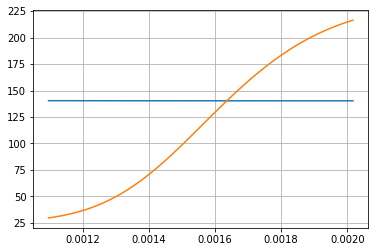

In [22]:
train_point_number = 1000
predicted_temps = [all_train_predicted[i][train_point_number] for i in range(70)]
actual_temps = [new_temps[train_indices[train_point_number]][i] for i in range(70)]
fig, ax = plt.subplots()
ax.plot(times[0:70], predicted_temps)
ax.plot(times[0:70], actual_temps)
plt.grid()

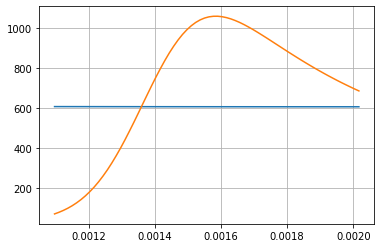

In [24]:
test_point_number = 203
predicted_temps = [all_test_predicted[i][test_point_number] for i in range(70)]
actual_temps = [new_temps[test_indices[test_point_number], i] for i in range(70)]
fig, ax = plt.subplots()
ax.plot(times[0:70], predicted_temps)
ax.plot(times[0:70], actual_temps)
plt.grid()